In [2]:
import boto3
import json
import base64
import cv2
from tqdm import tqdm
from PIL import Image
import io
import copy
from io import BytesIO
import numpy as np

ModuleNotFoundError: No module named 'boto3'

In [155]:
bedrock_client = boto3.client('bedrock-runtime', region_name='us-east-1')

In [156]:
def generate_message(bedrock_runtime, model_id, messages, max_tokens,top_p, temp):

    body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "messages": messages,
            "temperature": temp,
            "top_p": top_p
        }  
    )  
    
    response = bedrock_runtime.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response.get('body').read())

    return response_body

In [41]:
import cv2
from PIL import Image

cap = cv2.VideoCapture("20220924-0904-C5578.MP4")   # /dev/video0
all_video_frames = []
while True:
  ret, frame = cap.read()
  if not ret:
    break
  all_video_frames.append(cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), (256, 256)))

In [157]:
print(f"Found {len(all_video_frames)} frames in this video!")

Found 264 frames in this video!


In [158]:
video_prompt = []

def numpy_array_to_base64(numpy_array):
    # Step 1: Convert NumPy array to PIL image
    pil_image = Image.fromarray(numpy_array)
    
    # Step 2: Save the PIL image to a BytesIO object
    buffered = io.BytesIO()
    pil_image.save(buffered, format="PNG")
    
    # Step 3: Encode the BytesIO object to a base64 string
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    
    return img_str

for i, frame in tqdm(enumerate(all_video_frames)):
    if i % 14 == 0:
        pre_prompt = {
            "type": "text",
            "text": f"Video Frame {i+1}:"
        }
        image_base64_data = numpy_array_to_base64(frame)
        image_prompt = {
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": "image/jpeg",
                "data": image_base64_data
            }
        }
        video_prompt.append(pre_prompt)
        video_prompt.append(image_prompt)

264it [00:00, 346.36it/s]


In [159]:
print(len(video_prompt))

38


### Single Image Prompt

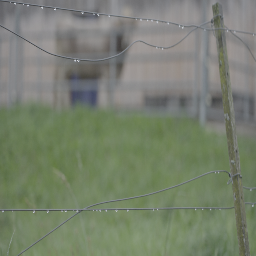

In [160]:
image_data = base64.b64decode(video_prompt[-25]['source']['data'])

# Step 2: Load the image using PIL
image = Image.open(BytesIO(image_data))

# Step 3: Convert the image to a NumPy array
image_np = np.array(image)

Image.fromarray(image_np)

In [161]:
message_mm=[

    { "role": "user",
      "content": [
      video_prompt[-25],
      {"type": "text","text": "Describe the image in one line?"}
      ]
    }
]


In [162]:
%%time 
message = generate_message(
    bedrock_client, 
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
    messages=message_mm, 
    max_tokens=512, 
    temp=0.5, 
    top_p=0.9
)

CPU times: user 17.3 ms, sys: 1.86 ms, total: 19.1 ms
Wall time: 1.33 s


In [163]:
message['content'][0]['text']

'The image shows a chain-link fence with barbed wire on top, blurred buildings in the background, and some grass or vegetation in the foreground, suggesting a restricted or secured area.'

### Video Prompt

In [164]:
sliced_video = copy.deepcopy(video_prompt)

In [165]:
sliced_video.append(
    {"type": "text", 
     "text": "You are an expert video description assistant. Above images are frames of a video, look at all the frames together and tell me what is going on from the first frame to the last frame in no more than 4 sentences."
    }
)

In [166]:
video_mm=[
    {
        "role": "user",
        "content": sliced_video
    }
]


In [167]:
%%time 
message = generate_message(
    bedrock_client, 
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
    messages=video_mm, 
    max_tokens=512, 
    temp=0.5, 
    top_p=0.9
)

CPU times: user 324 ms, sys: 7.2 ms, total: 331 ms
Wall time: 5.45 s


In [168]:
message['content'][0]['text']

'The video frames depict a group of sheep or goats behind a wire fence in a grassy area next to a wooden barn or shed. As the frames progress, raindrops start appearing and intensifying, indicating the onset of rainfall. The animals remain relatively still throughout the sequence, though there are some slight movements among them. The overall scene captures the animals sheltering near the structure during a rainy day in what appears to be a rural or farm setting.'